In [2]:
%load_ext line_profiler
# Import the game
import gym_super_mario_bros
# Import the Joypad wrapper
from nes_py.wrappers import JoypadSpace
# Import the SIMPLIFIED controls
from gym_super_mario_bros.actions import SIMPLE_MOVEMENT
import imageio
import numpy as np
import matplotlib.pyplot as plt
import cv2
# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

from collections import deque

from torchvision import transforms as T

import gym
from gym.spaces import Box
from gym.wrappers import FrameStack

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [4]:
env = gym_super_mario_bros.make("SuperMarioBros-v0", render_mode='rgb_array', apply_api_compatibility=True)
env = JoypadSpace(env, SIMPLE_MOVEMENT)

env.reset()
next_state, reward, done, trunc, info = env.step(action=0)

/Users/suvir/anaconda3/lib/python3.11/site-packages/gym/envs/registration.py:555: UserWarning: WARN: The environment SuperMarioBros-v0 is out of date. You should consider upgrading to version `v3`.
  logger.warn(
/Users/suvir/anaconda3/lib/python3.11/site-packages/gym/envs/registration.py:627: UserWarning: WARN: The environment creator metadata doesn't include `render_modes`, contains: ['render.modes', 'video.frames_per_second']
  logger.warn(
/Users/suvir/anaconda3/lib/python3.11/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


In [5]:
class SkipFrame(gym.Wrapper):
    def __init__(self, env, skip):
        """Return only every `skip`-th frame"""
        super().__init__(env)
        self._skip = skip

    def step(self, action):
        """Repeat action, and sum reward"""
        total_reward = 0.0
        for i in range(self._skip):
            # Accumulate reward and repeat the same action
            obs, reward, done, trunk, info = self.env.step(action)
            total_reward += reward
            if done:
                break
        return obs, total_reward, done, trunk, info


class GrayScaleObservation(gym.ObservationWrapper):
    def __init__(self, env):
        super().__init__(env)
        obs_shape = self.observation_space.shape[:2]
        self.observation_space = Box(low=0, high=255, shape=obs_shape, dtype=np.uint8)

    def permute_orientation(self, observation):
        # permute [H, W, C] array to [C, H, W] tensor
        observation = np.transpose(observation, (2, 0, 1))
        observation = torch.tensor(observation.copy(), dtype=torch.float)
        return observation

    def observation(self, observation):
        observation = self.permute_orientation(observation)
        transform = T.Grayscale()
        observation = transform(observation)
        return observation


class ResizeObservation(gym.ObservationWrapper):
    def __init__(self, env, shape):
        super().__init__(env)
        if isinstance(shape, int):
            self.shape = (shape, shape)
        else:
            self.shape = tuple(shape)

        obs_shape = self.shape + self.observation_space.shape[2:]
        self.observation_space = Box(low=0, high=255, shape=obs_shape, dtype=np.uint8)

    def observation(self, observation):
        transforms = T.Compose(
            [T.Resize(self.shape, antialias=True), T.Normalize(0, 255)]
        )
        observation = transforms(observation).squeeze(0)
        return observation


# Apply Wrappers to environment
env = SkipFrame(env, skip=4)
env = GrayScaleObservation(env)
env = ResizeObservation(env, shape=84)
env = FrameStack(env, num_stack=4)

In [6]:
s_size = env.observation_space.shape
a_size = env.action_space.n
print(env.observation_space.shape, s_size, a_size)

(4, 84, 84) (4, 84, 84) 7


In [7]:
class Policy(nn.Module):
    def __init__(self, s_size, a_size, h_size):
        super(Policy, self).__init__()
        # Define the three layers here
        # Code Here
        self.cnn = self.__build_cnn(4, a_size, h_size)

    def forward(self, x):
        # Define the forward process here (with ReLU activation for the first 2 layers)
        # x -> fc1 -> ReLU -> fc2 -> ReLU -> fc3
        # Code Here
        # x = torch.relu(self.fc1(x))
        # x = torch.relu(self.fc2(x))
        # x = self.fc3(x)

        # We output the softmax
        return F.softmax(self.cnn(x), dim=1)

    def act(self, state):
        state = np.array(state)
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        probs = self.forward(state).cpu()
        m = Categorical(probs)
        action = m.sample()
        return action.item(), m.log_prob(action)

    def __build_cnn(self, c, output_dim, hidden_dim):
        return nn.Sequential(
            nn.Conv2d(in_channels=c, out_channels=32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(3136, hidden_dim),
            # nn.Flatten(),
            # nn.Linear(1296, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim),
        )

In [8]:
def reinforce(policy, optimizer, n_training_episodes, max_t, gamma, print_every):
    # Help us to calculate the score during the training
    scores_deque = deque(maxlen=min(print_every, 100))
    scores = []
    # Line 3 of pseudocode
    for i_episode in range(1, n_training_episodes+1):
        saved_log_probs = []
        rewards = []
        state, _ = env.reset() # Code Here: reset the environment
        # Line 4 of pseudocode
        for t in range(max_t):
            action, log_prob = policy.act(state) # Code Here: get the action
            saved_log_probs.append(log_prob)
            state, reward, done, truncated, info = env.step(action) # Code Here: take an env step
            rewards.append(reward)
            if done:
                break
        print(f'finished run {i_episode}')
        scores_deque.append(sum(rewards))
        scores.append(sum(rewards))

        # Line 6 of pseudocode: calculate the return
        returns = deque(maxlen=max_t)
        n_steps = len(rewards)

        # Compute the discounted returns at each timestep,
        # as the sum of the gamma-discounted return at time t (G_t) + the reward at time t

        ## We compute this starting from the last timestep to the first, to avoid redundant computations

        ## appendleft() function of queues appends to the position 0
        ## We use deque instead of lists to reduce the time complexity

        for t in range(n_steps)[::-1]:
            disc_return_t = (returns[0] if len(returns)>0 else 0)
            returns.appendleft(rewards[t] + gamma * disc_return_t) # Code Here: complete here

        ## standardization for training stability
        eps = np.finfo(np.float32).eps.item()

        ## eps is added to the standard deviation of the returns to avoid numerical instabilities
        returns = torch.tensor(returns)
        returns = (returns - returns.mean()) / (returns.std() + eps)

        # Line 7:
        policy_loss = []
        for log_prob, disc_return in zip(saved_log_probs, returns):
            policy_loss.append(-log_prob * disc_return)
        policy_loss = torch.cat(policy_loss).sum()

        # Line 8: PyTorch prefers gradient descent
        optimizer.zero_grad()
        policy_loss.backward()
        optimizer.step()

        if i_episode % print_every == 0:
            print('Episode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))

    return scores

In [9]:
class AgentNN(nn.Module):
    def __init__(self, input_shape, n_actions, freeze=False):
        super().__init__()
        # Conolutional layers
        self.conv_layers = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU(),
        )

        conv_out_size = self._get_conv_out(input_shape)

        # Linear layers
        self.network = nn.Sequential(
            self.conv_layers,
            nn.Flatten(),
            nn.Linear(conv_out_size, 512),
            nn.ReLU(),
            nn.Linear(512, n_actions)
        )

        if freeze:
            self._freeze()
        
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.to(self.device)

    def forward(self, x):
        return self.network(x)

    def _get_conv_out(self, shape):
        o = self.conv_layers(torch.zeros(1, *shape))
        # np.prod returns the product of array elements over a given axis
        return int(np.prod(o.size()))
    
    def _freeze(self):        
        for p in self.network.parameters():
            p.requires_grad = False

In [10]:
!pip install tensordict
!pip install torchrl
from tensordict import TensorDict
from torchrl.data import TensorDictReplayBuffer, LazyMemmapStorage

In [11]:
class Agent:
    def __init__(self, 
                 input_dims, 
                 num_actions, 
                 lr=0.00025, 
                 gamma=0.9, 
                 epsilon=1.0, 
                 eps_decay=0.99999975, 
                 eps_min=0.1, 
                 replay_buffer_capacity=100_000, 
                 batch_size=32, 
                 sync_network_rate=10000):
        
        self.num_actions = num_actions
        self.learn_step_counter = 0

        # Hyperparameters
        self.lr = lr
        self.gamma = gamma
        self.epsilon = epsilon
        self.eps_decay = eps_decay
        self.eps_min = eps_min
        self.batch_size = batch_size
        self.sync_network_rate = sync_network_rate

        # Networks
        self.online_network = AgentNN(input_dims, num_actions)
        self.target_network = AgentNN(input_dims, num_actions, freeze=True)

        # Optimizer and loss
        self.optimizer = torch.optim.Adam(self.online_network.parameters(), lr=self.lr)
        self.loss = torch.nn.MSELoss()
        # self.loss = torch.nn.SmoothL1Loss() # Feel free to try this loss function instead!

        # Replay buffer
        storage = LazyMemmapStorage(replay_buffer_capacity)
        self.replay_buffer = TensorDictReplayBuffer(storage=storage)

    def choose_action(self, observation):
        if np.random.random() < self.epsilon:
            return np.random.randint(self.num_actions)
        # Passing in a list of numpy arrays is slower than creating a tensor from a numpy array
        # Hence the `np.array(observation)` instead of `observation`
        # observation is a LIST of numpy arrays because of the LazyFrame wrapper
        # Unqueeze adds a dimension to the tensor, which represents the batch dimension
        observation = torch.tensor(np.array(observation), dtype=torch.float32) \
                        .unsqueeze(0) \
                        .to(self.online_network.device)
        # Grabbing the index of the action that's associated with the highest Q-value
        return self.online_network(observation).argmax().item()
    
    def decay_epsilon(self):
        self.epsilon = max(self.epsilon * self.eps_decay, self.eps_min)

    def store_in_memory(self, state, action, reward, next_state, done):
        self.replay_buffer.add(TensorDict({
                                            "state": torch.tensor(np.array(state), dtype=torch.float32), 
                                            "action": torch.tensor(action),
                                            "reward": torch.tensor(reward), 
                                            "next_state": torch.tensor(np.array(next_state), dtype=torch.float32), 
                                            "done": torch.tensor(done)
                                          }, batch_size=[]))
        
    def sync_networks(self):
        if self.learn_step_counter % self.sync_network_rate == 0 and self.learn_step_counter > 0:
            self.target_network.load_state_dict(self.online_network.state_dict())

    def save_model(self, path):
        torch.save(self.online_network.state_dict(), path)

    def load_model(self, path):
        self.online_network.load_state_dict(torch.load(path))
        self.target_network.load_state_dict(torch.load(path))

    def learn(self):
        if len(self.replay_buffer) < self.batch_size:
            return
        
        self.sync_networks()
        
        self.optimizer.zero_grad()

        samples = self.replay_buffer.sample(self.batch_size).to(self.online_network.device)

        keys = ("state", "action", "reward", "next_state", "done")

        states, actions, rewards, next_states, dones = [samples[key] for key in keys]

        predicted_q_values = self.online_network(states) # Shape is (batch_size, n_actions)
        predicted_q_values = predicted_q_values[np.arange(self.batch_size), actions.squeeze()]

        # Max returns two tensors, the first one is the maximum value, the second one is the index of the maximum value
        target_q_values = self.target_network(next_states).max(dim=1)[0]
        # The rewards of any future states don't matter if the current state is a terminal state
        # If done is true, then 1 - done is 0, so the part after the plus sign (representing the future rewards) is 0
        target_q_values = rewards + self.gamma * target_q_values * (1 - dones.float())

        loss = self.loss(predicted_q_values, target_q_values)
        loss.backward()
        self.optimizer.step()

        self.learn_step_counter += 1
        self.decay_epsilon()


In [12]:
agent = Agent(input_dims=env.observation_space.shape, num_actions=env.action_space.n)

In [ ]:
SHOULD_TRAIN = True
DISPLAY = True
CKPT_SAVE_INTERVAL = 5000
NUM_OF_EPISODES = 50_000

SHOULD_TRAIN = True
env.reset()
next_state, reward, done, trunc, info = env.step(action=0)

for i in range(NUM_OF_EPISODES):    
    print("Episode:", i)
    done = False
    state, _ = env.reset()
    total_reward = 0
    while not done:
        a = agent.choose_action(state)
        new_state, reward, done, truncated, info  = env.step(a)
        total_reward += reward

        if SHOULD_TRAIN:
            agent.store_in_memory(state, a, reward, new_state, done)
            agent.learn()

        state = new_state

    print("Total reward:", total_reward, "Epsilon:", agent.epsilon, "Size of replay buffer:", len(agent.replay_buffer), "Learn step counter:", agent.learn_step_counter)

    if SHOULD_TRAIN and (i + 1) % CKPT_SAVE_INTERVAL == 0:
        agent.save_model(os.path.join(model_path, "model_" + str(i + 1) + "_iter.pt"))

    print("Total reward:", total_reward)

env.close()

Episode: 0
Total reward: 638.0 Epsilon: 0.9999707504241168 Size of replay buffer: 148 Learn step counter: 117
Total reward: 638.0
Episode: 1
Total reward: 1799.0 Epsilon: 0.9995456032126282 Size of replay buffer: 1849 Learn step counter: 1818
Total reward: 1799.0
Episode: 2
Total reward: 1580.0 Epsilon: 0.9994271640614847 Size of replay buffer: 2323 Learn step counter: 2292
Total reward: 1580.0
Episode: 3
Total reward: 1599.0 Epsilon: 0.9991068989405528 Size of replay buffer: 3605 Learn step counter: 3574
Total reward: 1599.0
Episode: 4
Total reward: 1773.0 Epsilon: 0.9987705062935295 Size of replay buffer: 4952 Learn step counter: 4921
Total reward: 1773.0
Episode: 5
Total reward: 1602.0 Epsilon: 0.9986616462277024 Size of replay buffer: 5388 Learn step counter: 5357
Total reward: 1602.0
Episode: 6
Total reward: 977.0 Epsilon: 0.9982390520708483 Size of replay buffer: 7081 Learn step counter: 7050
Total reward: 977.0
Episode: 7
Total reward: 1053.0 Epsilon: 0.998181654968354 Size of r

In [ ]:
mario_params = {
    "h_size": 512,
    "n_training_episodes": 1000,
    "n_evaluation_episodes": 10,
    "max_t": 10000,
    "gamma": 0.99,
    "lr": 0.00025,#1e-4,
    "state_space": s_size,
    "action_space": a_size,
}

In [ ]:
mario_policy = Policy(mario_params["state_space"], mario_params["action_space"], mario_params["h_size"]).to(device)
mario_optimizer = optim.Adam(mario_policy.parameters(), lr=mario_params["lr"])

In [ ]:
# %lprun -f reinforce reinforce(mario_policy, mario_optimizer, mario_params["n_training_episodes"], mario_params["max_t"], mario_params["gamma"], 1)
scores = reinforce(mario_policy,
                   mario_optimizer,
                   mario_params["n_training_episodes"],
                   mario_params["max_t"],
                   mario_params["gamma"],
                   10)

In [14]:
def record_video(env, policy, out_directory, fps=30, max_frames = 1000):
  images = []
  done = False
  state, _ = env.reset()
  frame_counter = 0
  while not done and frame_counter < max_frames:
    action, _ = policy.act(state)
    state, reward, done, tunc, info = env.step(action)
    img = env.render()
    x = img.copy()
    images.append(x)
    frame_counter += 1
  imageio.mimsave(out_directory, [np.array(img) for img in images], fps=fps)

In [15]:
record_video(env, mario_policy, './replay.mp4', 30)

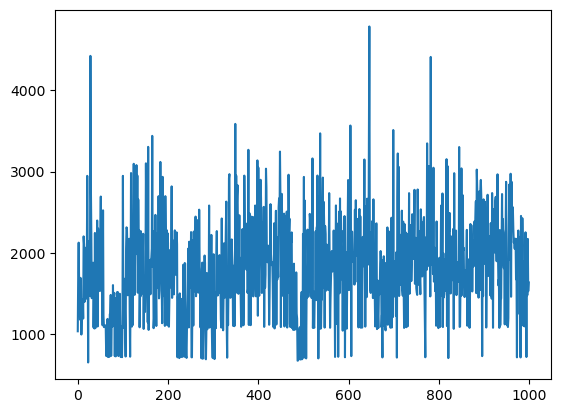

In [13]:
plt.plot(scores)